# CSP based classification

Common spatial pattern (CSP) is a technique often used in Motor Imagery (MI) EEG-based BCIs to extract characteristic neural features from epochs.
These features can then be used as input for more traditional Machine Learning (ML) methods to obtain a minimal working BCI pipeline, although filtering of the signal before using CSP is also recommended.
CSP projects the multi-channel EEG data onto a lower-dimensional spatial subspace by using a projection matrix.
This process is capable of maximizing the variance between the different classes and thus makes more information-carrying features than plain RAW EEG data ([Bhattacharyya et al](https://doi.org/10.1016/B978-0-12-821413-8.00017-8)).

According to ([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)), the desired frequency band for MI classification is 8-30 Hz. 
This includes the Alpha (8-13 Hz) and Beta (14-30 Hz) waves.
To do such a filtering, band-pass filters are recommended, of which there exist different approaches.
([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)) used a third-order Butterworth band-pass filter for this.
([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)) also goes into further depth on the working of CSP, a technique first used by Ramoser et al [2000](10.1109/86.895946) to classify MI data but already known to exist for EEG with the first mentions by [Koles et al](https://doi.org/10.1007/BF01129656).

In this notebook, we explore this CSP technique for feature generation and combine it with a wide variety of datasets and classification algorithms in multiple small pipelines.
This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in previous notebooks. Since the original dataset by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) was provided in MatLab files, FIF files for the python MNE datatypes are made available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

We rely in part on the [MNE provided tutorials](https://mne.tools/dev/auto_examples/decoding/index.html) for this notebook.
We also play with the Grid Search CV capabilities of the Sci-Kit learn library in this notebook.

## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- A word on filtering and CSP
- Band-pass filter to CSP to LDA pipeline
  - Fixed window classification: Single trial | CSP + LDA | Binary left-right MI task
  - Fixed window classification: Single trial | CSP + LDA | three class MI task
  - Fixed window classification: Multi trial | CSP + LDA | Binary left-right MI task
  - Fixed window classification: Multi trial | CSP + LDA | three class MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | binary left-right MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | three class MI task
- Band-pass filter to CSP to SVM pipeline
  - Fixed window classification: Single trial | CSP + SVM | three class MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + SVM | three class MI task
- Band-pass filter to CSP to RF pipeline (TODO)
- Band-pass filter to CSP to KNN pipeline (TODO)

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules and show if the versions match those that are recommended.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. FIF files from this same dataset are also made available in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). A check on the availability of these two datasets is performed below.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data.
The loaded data is that of a specific subject and thus can exist of multiple MNE RAW objects.
This list of objects is provided as well as a singular one, namely the first of the list.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [4]:
####################################################
# LOADING RAW MNE DATA AND EPOCS
####################################################

# You can specify the data file to use here, per default it is CLASubjectB1512153StLRHand
subject = "C"

# Load RAW MNE
mne_raws = CLA_dataset.get_raw_mne_data_for_subject("C")
mne_raw = mne_raws[0]
print(f"Loaded MNE raw for subject {subject}: {len(mne_raws)} files, last file: \n")
display(mne_raw)



Loaded MNE raw for subject C: 3 files, last file: 



<Raw | CLASubjectC1511263StLRHand_raw.fif, 21 x 666800 (3334.0 s), ~37 kB, data not loaded>

<hr><hr>

## A word on filtering and CSP

At the beginning of this notebook, a short explanation of filtering and CSP is already given.
As these are very important concepts, some more details are given here, mainly based on the work by ([Bhattacharyya et al](https://doi.org/10.1016/B978-0-12-821413-8.00017-8)) and ([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)).

The raw EEG data of the CLA dataset used in this notebook is recorded at a sampling frequency of 200Hz.
According to Nyquist's theorem, this enables the reliable detection of a periodic signal with a frequency of at most 100Hz.
Luckily, MI data relies mostly on Alpha and Beta waves.
Alpha and beta waves are often specified as being from 8-12Hz whilst Beta waves are said to be from 12–35Hz.
However, the exact distributions are not agreed upon and the frequencies to include for the MI classification task vary in the field.
According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz.
[Kirar and Agrawal](10.1109/SSCI.2018.8628719) specify it is as 7-30Hz and variations are seen up to 0-40Hz.
This should ideally be part of the training when working on a patient per patient basis ([Blankertz et al](10.1016/j.neuroimage.2007.01.051)).
Besides filtering the data, making a subselection of the electrodes is often also performed to reduce the dimensionality and thus the complexity of the data further.

Common spatial pattern (CSP) is a technique used in Motor Imagery (MI) EEG-based BCIs to extract characteristic neural features from epochs.
CSP is proven to be a computationally simple data-driven spatial filtering technique that offers great results and can be easily implemented through libraries such as [MNE](https://doi.org/10.1016/j.neuroimage.2013.10.027).
Being data-driven, CSP is noise sensitive and requires sufficient samples to perform well.
Nonetheless, the ease of use makes it a popular approach in the field to generate features used for training more traditional Machine Learning (ML) classifiers such as Support Vector Machines (SVMs), Random Forest (RF) and K Nearest Neighbours (KNN) amongst others.
CSP was originally meant to be used in binary settings, however, multiclass variants have been proposed and are widely used as well, MNE uses the multi-class approach by [Grosse-Wentrup and Buss](10.1109/TBME.2008.921154).
Many variants of CSP exist as well, some are shown to perform up to 10% better for users where CSP has poor performance [Lotte and Guan](10.1109/ICPR.2010.904).

CSP is thoroughly explained by [Blankertz et al](10.1109/MSP.2008.4408441), where variants and optimisation tricks are also discussed.
As discussed, regular CSP is a binary method to analyze multichannel data based on recordings from two classes ([Blankertz et al](10.1109/MSP.2008.4408441)).
[Blankertz et al](10.1109/MSP.2008.4408441) goes into further details on the math.
In essence, CSP aims to maximize the variance of the spatially filtered signal for one class whilst minimizing it for the other class ([Blankertz et al](10.1109/MSP.2008.4408441)).
Since CSP relies on band power, appropriate band-pass filtering before using CSP is recommended to extract MI specific waves.



<hr><hr>

## Band-pass filter to CSP to LDA pipeline

We first combine a band-pass filter with Common Spatial Patterns (CSP) and Linear Discriminant Analysis (LDA) to form a first minimal BCI pipeline.
We do this in a variety of ways.

<hr>

### Fixed window classification: Single trial | CSP + LDA | Binary left-right MI task

We start with fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We use overlap-add FIR filtering to extract more MI specific frequencies.

Since CSP was originally meant to be used in a binary setting, we start with a binary variant of the CLA dataset only containing `task/left` and `task/right`.
The CSP configuration is manually hyper-tuned to see how it evolves using different settings.

We then use a non-hyper-tuned LDA for the classification of these features.

The found classification results for subject `C` are:
- Using file at index 0
  - Performed cross fold validation and got an average classification score of 0.9654450261780104 with a standard deviation of 0.006282722513089026
  - Fitted pipeline a single time and got a classification accuracy of 0.9842931937172775
- Using file at index 1
  - Performed cross fold validation and got an average classification score of 0.9298429319371728 with a standard deviation of 0.019757028548809626
  - Fitted pipeline a single time and got a classification accuracy of 0.9109947643979057
- Using file at index 2
  - Performed cross fold validation and got an average classification score of 0.8638743455497382 with a standard deviation of 0.022701029726365233
  - Fitted pipeline a single time and got a classification accuracy of 0.8167539267015707

From this we can see the inter-patient variance is significantly large.



In [5]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to binary classification
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Loading data for 636 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:



Number of events,636
Events,task/left: 322task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Got the band-pass filtered epochs: 



Number of events,636
Events,task/left: 322task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Extracted labels from epochs: [1 2 1 1 2 2 2 1 1 2]


Performed cross fold validation and got an average classification score of 0.9654450261780104 with a standard deviation of 0.006282722513089026
Fitted pipeline a single time and got a classification accuracy of 0.9842931937172775


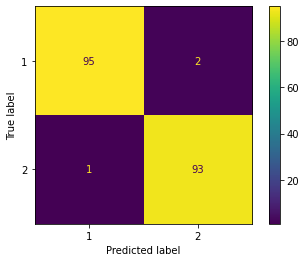

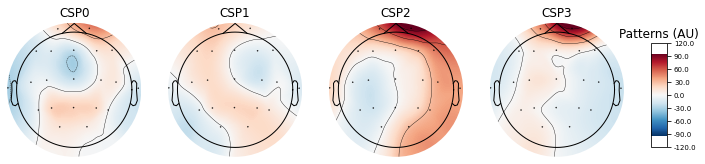

In [6]:
####################################################
# FIXED WINDOW: CSP + LDA (BINARY)
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=4,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [7]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Single trial | CSP + LDA | three class MI task

We continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We now include all three MI tasks from the CLA dataset, this includes `task/neutral` next to the previous `task/left` and `task/right`.
The CSP configuration is adopted from before but the amount of components is increased to 6, following the reasoning that there also was a 50% increase in classes.

We then use a non-hyper-tuned LDA for the classification of these features.

The found classification results for subject `C` are:
- Using file at index 0
  - Performed cross fold validation and got an average classification score of 0.8666666666666666 with a standard deviation of 0.011744121198116483
  - Fitted pipeline a single time and got a classification accuracy of 0.8854166666666666
- Using file at index 1
  - Performed cross fold validation and got an average classification score of 0.7881944444444445 with a standard deviation of 0.04275206658783718
  - Fitted pipeline a single time and got a classification accuracy of 0.7569444444444444
- Using file at index 2
  - Performed cross fold validation and got an average classification score of 0.7118055555555556 with a standard deviation of 0.01388888888888889
  - Fitted pipeline a single time and got a classification accuracy of 0.5902777777777778

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|
| 0              | 0.867 +- 0.012                           | 0.885                              |
| 1              | 0.788 +- 0.043                           | 0.757                              |
| 2              | 0.712 +- 0.014                           | 0.590                              |

From this we can see the inter-patient variance is significantly large.



In [8]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Loading data for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Got the band-pass filtered epochs: 



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


Performed cross fold validation and got an average classification score of 0.8666666666666666 with a standard deviation of 0.011744121198116483
Fitted pipeline a single time and got a classification accuracy of 0.8854166666666666


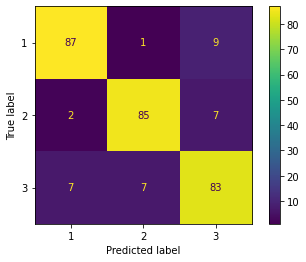

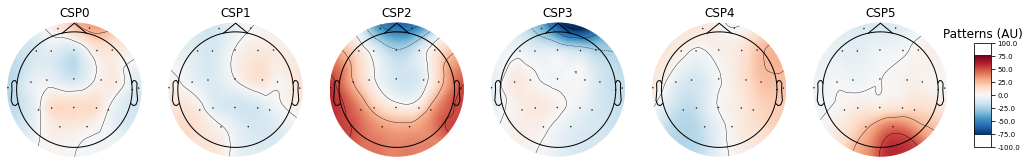

In [9]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [10]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Multi trial | CSP + LDA | Binary left-right MI task

The previous results were statisfactory but for one trial only.
This is bound to give an over estimation of real-life performance where multiple trials exist.
The fixed window and some other aspects are also unrealistic but are kept for now to see the individual impact.


Thus, we continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
But we combine the epochs of all trials from the patient, which introduces variability and will likely decrease performance of the model.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We again start by using only two MI tasks from the CLA dataset (`task/left` and `task/right`).
The CSP configuration is adopted from the previous binary experiment as well, having 4 components.

We still use a non-hyper-tuned LDA for the classification of these features.



In [11]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels = []

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    epochs.append(mne_fixed_window_epochs)
    print(f"Loaded and filtered epochs")
    
    # Labels: should be integers!
    labels.extend(mne_fixed_window_epochs.events[:, -1])
    print(f"Extracted labels from epochs")
    
# Make single epoch object
mne_fixed_window_epochs = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated all epochs")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)
print(f"\n\nTotal amount of labels: {len(labels)}")

# Remove unused variables
del epochs
del single_mne_raw



Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Concatenated all epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_16197/1941466830.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs = mne.concatenate_epochs(epochs, verbose=False)


Number of events,1907
Events,task/left: 965task/right: 942
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>



Total amount of labels: 1907


Performed cross fold validation and got an average classification score of 0.8795811518324607 with a standard deviation of 0.017170504539265403
Fitted pipeline a single time and got a classification accuracy of 0.900523560209424


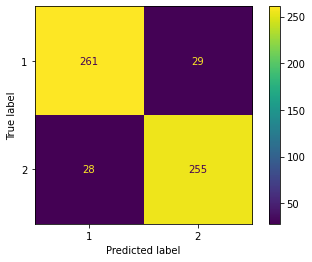

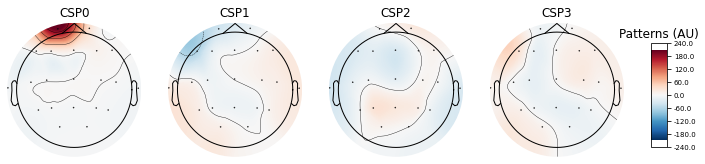

In [12]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=4,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

<hr>

### Fixed window classification: Multi trial | CSP + LDA | three class MI task

The previous results were statisfactory but for the binary variant.
The three class variant is more usefull for most if not all applications.


Thus, we continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We still combine the epochs of all trials from the patient.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We now include all three MI tasks from the CLA datases (`task/neutral`, `task/left` and `task/right`).
The CSP configuration is changed as before, having 6 components now to compensate for the extra label.

We still use a non-hyper-tuned LDA for the classification of these features.



In [13]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels = []

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    epochs.append(mne_fixed_window_epochs)
    print(f"Loaded and filtered epochs")
    
    # Labels: should be integers!
    labels.extend(mne_fixed_window_epochs.events[:, -1])
    print(f"Extracted labels from epochs")
    
# Make single epoch object
mne_fixed_window_epochs = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated all epochs")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)
print(f"\n\nTotal amount of labels: {len(labels)}")

# Remove unused variables
del epochs
del single_mne_raw



Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_16197/2817143996.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs = mne.concatenate_epochs(epochs, verbose=False)




Concatenated all epochs


Number of events,2879
Events,task/left: 965task/neutral: 972task/right: 942
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>



Total amount of labels: 2879


Performed cross fold validation and got an average classification score of 0.7145833333333333 with a standard deviation of 0.005791664816294806
Fitted pipeline a single time and got a classification accuracy of 0.7465277777777778


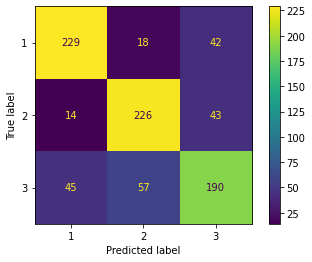

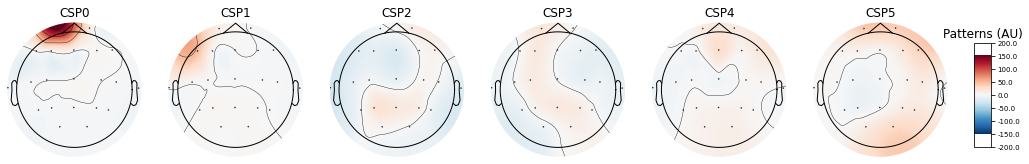

In [14]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [15]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | binary left-right MI task

The previous results were statisfactory for multi-trial classification.
However, the train/test split happened over all trials and thus training data from all trials is available.
More realisticly, we should have train and test trials.

All other settings remain unchanged from the previous binary experiment.
Thus, we continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We still include two of the MI tasks from the CLA datases (`task/left` and `task/right`).
The CSP configuration is adopted from before as well, having 4 components.

We still use a non-hyper-tuned LDA for the classification of these features.

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on seperate test trial of: 0.9072327044025157
- Using index 1 as test and others as train:
  - Found accuracy on seperate test trial of: 0.8836477987421384
- Using index 2 as test and others as train:
  - Found accuracy on seperate test trial of: 0.5874015748031496
- Using index 0 as test and training on index 1:
  - Found accuracy on seperate test trial of: 0.8773584905660378
- Using index 1 as test and training on index 0:
  - Found accuracy on seperate test trial of: 0.8632075471698113


Again, we notice huge differences in performance depending on the used trials/runs.



In [16]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated train epochs")
display(mne_fixed_window_epochs_train)
display(mne_fixed_window_epochs_train.info)
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nTest epochs")
display(mne_fixed_window_epochs_test)
display(mne_fixed_window_epochs_test.info)
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw



Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated train epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_16197/1083576271.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,1271
Events,task/left: 643task/right: 628
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1512163StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-12-16 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 1271


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_16197/1083576271.py:53: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)




Test epochs


Number of events,636
Events,task/left: 322task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 636


Found accuracy on seperate test trial of: 0.9072327044025157


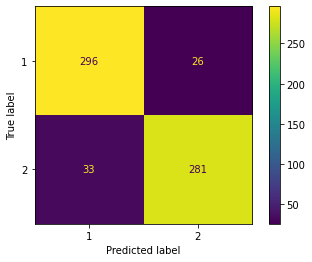

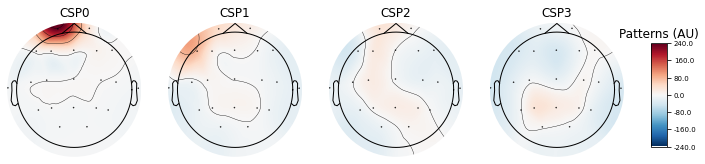

In [17]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=4,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline on the train trial(s)
    csp_lda_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_lda_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on seperate test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_lda_pipeline
del labels_test_predict
del lda
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test


<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | three class MI task

The previous results were statisfactory for some combinations.
We now do the same for three class MI.

All other settings remain unchanged from the previous experiment.
Thus, we continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We include all three MI tasks from the CLA datases (`task/neutral`, `task/left` and `task/right`).
The CSP configuration is adopted from before as well, having 6 components.

We still use a non-hyper-tuned LDA for the classification of these features.

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on seperate test trial of: 0.7333333333333333
- Using index 1 as test and others as train:
  - Found accuracy on seperate test trial of: 0.621875
- Using index 2 as test and others as train:
  - Found accuracy on seperate test trial of: 0.3899895724713243
- Using index 0 as test and training on index 1:
  - Found accuracy on seperate test trial of: 0.7145833333333333
- Using index 1 as test and training on index 0:
  - Found accuracy on seperate test trial of: 0.6635416666666667


Again, we notice huge differences in performance.



In [18]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated train epochs")
display(mne_fixed_window_epochs_train)
display(mne_fixed_window_epochs_train.info)
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nTest epochs")
display(mne_fixed_window_epochs_test)
display(mne_fixed_window_epochs_test.info)
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw



Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated train epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_16197/3187648474.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,1919
Events,task/left: 643task/neutral: 648task/right: 628
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1512163StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-12-16 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 1919


Test epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_16197/3187648474.py:53: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 960


Found accuracy on seperate test trial of: 0.7333333333333333


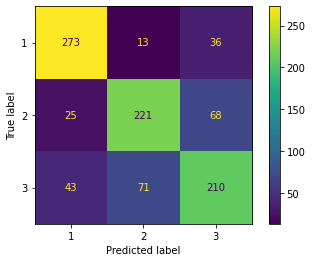

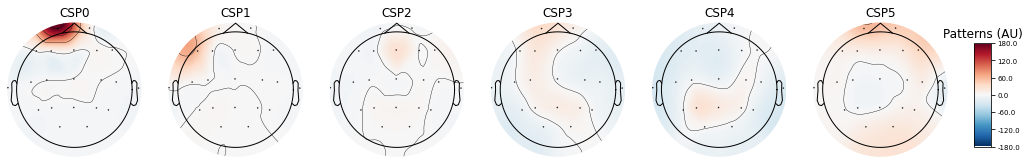

In [19]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline on the train trial(s)
    csp_lda_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_lda_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on seperate test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_lda_pipeline
del labels_test_predict
del lda
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test


In [20]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_train
del labels_test
del labels_train

<hr><hr>

## Band-pass filter to CSP to SVM pipeline

When looking at papers using CSP, for example, the [numerous BCI competition made papers](https://www.bbci.de/competition/iv/results/index.html), a pipeline often looks like this:

1. Passband filtering per subject
2. Multiclass CSP
3. Multiclass SVM

This is very similar to our previous pipeline with only the used classifier being different.
Because of this, we will now use a pipeline with an SVM classifier.
It is noted that SVM does need hyperparameter tuning to be optimal.
We did this hyperparameter tuning through a cross fold validated grid search using the specified parameters.
We only did the hyperparameter tuning for the first index and reused the found configuration for all indexes.
Redoing the optimisations could likely improve the results further.

<hr>

### Fixed window classification: Single trial | CSP + SVM | three class MI task

We start with the simpler task of classifying data from the same trial/run/session.
Ideally, performance should be better than the LDA performance for this task.
Since we see the performance of the file at index 1 was improved significantly by using this pipeline, we performed another grid search for the file at index 2 to see if improvements can be made.
This smaller grid search is also stored and made available.
The found scores are the latter of the two given, no significant difference was found.


| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|
| 0              | 0.867 +- 0.012                           | 0.885                              | 0.892 +- 0.010                           | 0.896                              |
| 1              | 0.788 +- 0.043                           | 0.757                              | 0.849 +- 0.012                           | 0.847                              |
| 2              | 0.712 +- 0.014                           | 0.590                              | 0.735 +- 0.016 / 0.751 +- 0.006          | 0.719 / 0.719                      |


In [25]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Loading data for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Got the band-pass filtered epochs: 



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


In [19]:
####################################################
# HYPERPARAMETER TUNING: CSP + SVM
####################################################

# Disable long execution per default
if False:
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold and keeping in mind computational power
    cv = ShuffleSplit(n_splits=3,
                        test_size=0.3,
                        random_state=98)



    # Initialize CSP and SVM 
    csp = CSP(norm_trace=False, component_order="mutual_info")
    svm = SVC()

    # Use scikit-learn Pipeline to connect CSP and SVM with "fixed" parameters
    csp_svm_pipeline = Pipeline([('CSP', csp), ('SVM', svm)])

    # Use gridsearch for parameter tuning (narrowed for computational power)
    param_grid = {
        "CSP__n_components": [3, 4, 7, 10],
        "CSP__reg": ["empirical", "oas", "shrunk"],
        "CSP__cov_est": ["concat", "epoch"],
        "SVM__C": [0.1, 1, 10, 100],
        "SVM__kernel": ['linear', 'rbf', 'poly', 'sigmoid'],
        "SVM__gamma":['scale', 'auto', 1, 0.1, 0.01, 0.001],
        }
    
    
    param_grid_faster = {
        "CSP__n_components": [6, 10],
        "CSP__reg": ["empirical", "oas"],
        "CSP__cov_est": ["concat", "epoch"],
        "SVM__C": [0.1, 1, 10, 100],
        "SVM__kernel": ['linear', 'rbf', 'sigmoid'],
        "SVM__gamma":['scale', 'auto', 1, 0.1, 0.01, 0.001],
        }

    grid_search = GridSearchCV(estimator= csp_svm_pipeline,
                            param_grid= param_grid,
                            n_jobs= -1,
                            refit= False,
                            cv= cv,
                            verbose= 10)

    # Do the grid search
    grid_search.fit(X= mne_fixed_window_epochs_data, 
                y= labels)
    
    # Print update
    print(f"\n\n... Grid search finished ...")

    # Store the results
    with open("saved_variables/4/gridsearch_csp_svm_single3_scores_index0.pickle", 'wb') as f:
            pickle.dump(grid_search, f)
            
    # Remove unsused variables
    del mne_fixed_window_epochs_data
    del cv
    del csp
    del svm
    del csp_svm_pipeline
    del param_grid
    del param_grid_faster
    del grid_search
    
# Open from file
## Full search for index 0: gridsearch_csp_svm_single3_scores_index0
## Quicker search for index 2: gridsearch_csp_svm_single3_scores_index2_faster
with open("saved_variables/4/gridsearch_csp_svm_single3_scores_index0.pickle", 'rb') as f:
    grid_search = pickle.load(f);

# Print the results
print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
print(grid_search.best_params_)

# Get grid search results
grid_search_results = pd.DataFrame(grid_search.cv_results_)

# Keep relevant columns and sort on rank
grid_search_results.drop(labels='params', axis=1, inplace= True)
grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

# Display grid search resulst
print("\n\n Top 10 grid search results: ")
display(grid_search_results.head(10))
print("\n\n Worst 10 grid search results: ")
display(grid_search_results.tail(10))

# Display some statistics
print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
max_score = grid_search_results['mean_test_score'].max()
print(f"The best mean test score is {round(max_score, 4)}")
shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
print(f"There are {shared_first_place_count} configurations with this maximum score")
close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.2, max_score)])
print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

# Display statistics for best classifiers
print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.2, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results



Best estimator has accuracy of 0.8958333333333334 with parameters
{'CSP__cov_est': 'concat', 'CSP__n_components': 10, 'CSP__reg': 'empirical', 'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__cov_est,param_CSP__n_components,param_CSP__reg,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
888,0.372215,0.037031,0.005665,4.710332e-04,concat,10,empirical,1,scale,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
2048,2.300929,0.009101,0.004665,4.711457e-04,epoch,10,empirical,1,1,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
2052,2.279936,0.025308,0.004999,4.052337e-07,epoch,10,empirical,1,0.1,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
2056,2.295265,0.012079,0.005332,4.712580e-04,epoch,10,empirical,1,0.01,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
2060,2.302595,0.030762,0.004998,1.946680e-07,epoch,10,empirical,1,0.001,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
2044,2.288265,0.024049,0.005332,4.711457e-04,epoch,10,empirical,1,auto,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
908,0.379546,0.019252,0.005999,6.836514e-07,concat,10,empirical,1,0.001,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1
955,0.371548,0.024950,0.006998,8.165347e-04,concat,10,empirical,100,0.01,sigmoid,0.909722,0.892361,0.885417,0.895833,0.010222,1
2107,2.317590,0.039798,0.005999,2.973602e-07,epoch,10,empirical,100,0.01,sigmoid,0.909722,0.892361,0.885417,0.895833,0.010222,1
904,0.369881,0.018773,0.005665,4.714266e-04,concat,10,empirical,1,0.01,linear,0.909722,0.892361,0.885417,0.895833,0.010222,1




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__cov_est,param_CSP__n_components,param_CSP__reg,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1078,2.867414,0.064859,0.009331,4.702484e-04,concat,10,shrunk,0.1,0.001,poly,0.315972,0.409722,0.309028,0.344907,0.045919,2291
1074,2.856086,0.043167,0.009330,4.706966e-04,concat,10,shrunk,0.1,0.01,poly,0.315972,0.409722,0.309028,0.344907,0.045919,2291
1122,2.854419,0.021786,0.008997,8.485379e-07,concat,10,shrunk,10,0.01,poly,0.315972,0.409722,0.309028,0.344907,0.045919,2291
2278,78.387230,0.216790,0.008664,4.713144e-04,epoch,10,shrunk,10,0.001,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298
2250,78.345243,0.259935,0.008331,4.710332e-04,epoch,10,shrunk,1,0.01,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298
2226,78.443212,0.116285,0.007998,1.946680e-07,epoch,10,shrunk,0.1,0.01,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298
2254,78.316253,0.149408,0.007997,5.947204e-07,epoch,10,shrunk,1,0.001,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298
2302,78.430550,0.239367,0.007664,4.713704e-04,epoch,10,shrunk,100,0.001,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298
2230,78.646481,0.145596,0.007997,2.973602e-07,epoch,10,shrunk,0.1,0.001,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298
2274,78.375901,0.225192,0.007997,4.899036e-07,epoch,10,shrunk,10,0.01,poly,0.315972,0.375000,0.309028,0.333333,0.029599,2298




In total there are 2304 different configurations tested.
The best mean test score is 0.8958
There are 14 configurations with this maximum score
There are 1895 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__cov_est,param_CSP__n_components,param_CSP__reg,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
count,1895.000000,1895.000000,1895.000000,1895.000000,1895,1895.0,1895,1895.0,1895,1895,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000
unique,NaN,NaN,NaN,NaN,2,4.0,3,4.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,concat,10.0,empirical,100.0,scale,linear,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,963,478.0,642,517.0,376,576,NaN,NaN,NaN,NaN,NaN,NaN
mean,13.929522,0.060271,0.007139,0.000479,NaN,NaN,NaN,NaN,NaN,NaN,0.851107,0.861305,0.845936,0.852783,0.012322,933.947757
std,28.166991,0.142445,0.004093,0.000539,NaN,NaN,NaN,NaN,NaN,NaN,0.047971,0.035912,0.043357,0.039948,0.010799,555.888381
min,0.349889,0.000817,0.002666,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.604167,0.687500,0.645833,0.697917,0.000000,1.000000
25%,0.418699,0.020230,0.004332,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,0.829861,0.850694,0.840278,0.841435,0.007135,470.000000
50%,2.327254,0.027643,0.005665,0.000471,NaN,NaN,NaN,NaN,NaN,NaN,0.864583,0.871528,0.861111,0.864583,0.010222,935.000000
75%,2.898906,0.050563,0.008664,0.000472,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,0.888889,0.871528,0.881944,0.014548,1410.000000


From the above grid search, it becomes apparent that the configuration changes can give rise to significant performance changes.
With a maximum mean test score of 0.895833 and a minimum of 0.333333, we get very good at exactly random behaviour!
However, when looking at how many configurations fall between 2% of the accuracy score of the best configuration, it is also obvious that many of the configurations are sufficient and only some settings will drastically reduce the performance rather than increase it.
Because many of the results lie so close and we only performed the hyperparameter tuning for the first file index, we use a configuration we think is the most fit.
Most noteably we use RBF instead of linear to allow for non linearity opposed to the linearity of the previously used LDA.

Performed cross fold validation and got an average classification score of 0.8916666666666666 with a standard deviation of 0.009672491859155655
Fitted pipeline a single time and got a classification accuracy of 0.8958333333333334


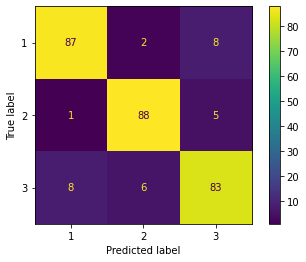

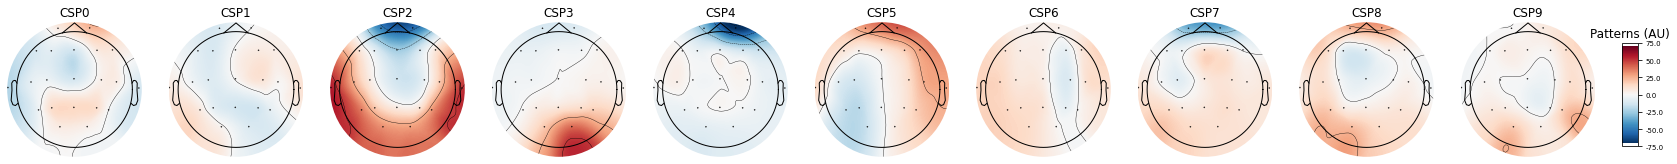

In [26]:
####################################################
# FIXED WINDOW: CSP + SVM
####################################################

# Specify the best found parameters
## Best found params for index 1 file: {'CSP__cov_est': 'concat', 'CSP__n_components': 10, 'CSP__reg': 'empirical', 'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
## Best found params for index 2 file: {'CSP__cov_est': 'epoch', 'CSP__n_components': 10, 'CSP__reg': 'empirical', 'SVM__C': 100, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
best_CSP__n_components = 10
best_CSP__reg = "empirical"
best_CSP__cov_est = "epoch"
best_SVM__C = 1
best_SVM__kernel = "rbf"
best_SVM__gamma = "scale"


with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=best_CSP__n_components,
        reg= best_CSP__reg,
        cov_est= best_CSP__cov_est,
        norm_trace=False,
        component_order="mutual_info")

    # Configre SVM
    svm = SVC(
        C= best_SVM__C,
        kernel= best_SVM__kernel,
        gamma= best_SVM__gamma
    )

    # Use scikit-learn Pipeline to connect CSP and SVM
    csp_svm_pipeline = Pipeline([('CSP', csp), ('SVM', svm)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_svm_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_svm_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_svm_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del svm
del csp_svm_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp
del best_CSP__n_components
del best_CSP__reg
del best_CSP__cov_est
del best_SVM__C
del best_SVM__kernel
del best_SVM__gamma

In [27]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + SVM | three class MI task

We saw an increase in performance by using a hypertuned SVM model for the classification.
These results where most significant for the file at index 1.
We test if there is an improvement in the case of testing on a seperate trial/session as well.
If this would be the case, it would suggest a better general model for that user is found, which would be excellent.
There is no re-optimisation of the pipeline.

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on seperate test trial of: 0.7822916666666667 (lda: 0.7333333333333333)
- Using index 1 as test and others as train:
  - Found accuracy on seperate test trial of: 0.6354166666666666 (lda: 0.621875)
- Using index 2 as test and others as train:
  - Found accuracy on seperate test trial of: 0.3472367049009385 (lda: 0.3899895724713243)
  - Never predicts 3 -> `task/neutral`
- Using index 0 as test and training on index 1:
  - Found accuracy on seperate test trial of: 0.6666666666666666 (lda: 0.7145833333333333)
- Using index 1 as test and training on index 0:
  - Found accuracy on seperate test trial of: 0.6625 (lda: 0.6635416666666667)

In [38]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated train epochs")
display(mne_fixed_window_epochs_train)
display(mne_fixed_window_epochs_train.info)
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nTest epochs")
display(mne_fixed_window_epochs_test)
display(mne_fixed_window_epochs_test.info)
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw



Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated train epochs


C:\Users\Lennert\AppData\Local\Temp\ipykernel_3660\3187648474.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,1919
Events,task/left: 643task/neutral: 648task/right: 628
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1512163StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-12-16 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 1919


Test epochs


C:\Users\Lennert\AppData\Local\Temp\ipykernel_3660\3187648474.py:53: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 960


Found accuracy on seperate test trial of: 0.7822916666666667


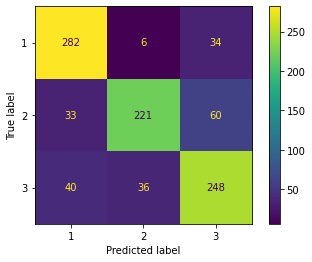

In [39]:
####################################################
# FIXED WINDOW: CSP + SVM
####################################################

# Specify the best found parameters
best_CSP__n_components = 10
best_CSP__reg = "empirical"
best_CSP__cov_est = "epoch"
best_SVM__C = 1
best_SVM__kernel = "rbf"
best_SVM__gamma = "scale"

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=best_CSP__n_components,
        reg= best_CSP__reg,
        cov_est= best_CSP__cov_est,
        norm_trace=False,
        component_order="mutual_info")

    # Configre SVM
    svm = SVC(
        C= best_SVM__C,
        kernel= best_SVM__kernel,
        gamma= best_SVM__gamma
    )

    # Use scikit-learn Pipeline to connect CSP and SVM
    csp_svm_pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline on the train trial(s)
    csp_svm_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_svm_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on seperate test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
#with io.capture_output():
#    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
#csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
#plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_svm_pipeline
del labels_test_predict
del svm
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test
del best_CSP__n_components
del best_CSP__reg
del best_CSP__cov_est
del best_SVM__C
del best_SVM__kernel
del best_SVM__gamma


In [40]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_train
del labels_test
del labels_train